## Recommendation System - Part I
### Product popularity based recommendation system targeted at new customers
* Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine.
[[](http://)](http://)
* **Dataset : **[Amazon product review dataset](https://www.kaggle.com/skillsmuggler/amazon-ratings)

#### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

#### Loading the dataset

In [3]:
amazon_ratings = pd.read_csv('../input/amazon-ratings/ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [4]:
amazon_ratings.shape

(2023070, 4)

In [5]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


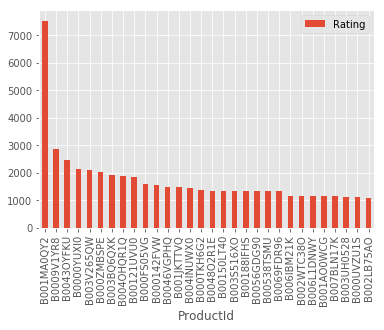

In [6]:
most_popular.head(30).plot(kind = "bar")

** Analysis:**

* The above graph gives us the most popular products (arranged in descending order) sold by the business.

* For eaxmple, product, ID # B001MA0QY2 has sales of over 7000, the next most popular product, ID # B0009V1YR8 has sales of  3000, etc.     

## Recommendation System - Part II
### Model-based collaborative filtering system

* Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.
* A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.

#### Utility Matrix based on products sold and user reviews
**Utility Matrix : **An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [7]:
# Subset of Amazon Ratings

amazon_ratings1 = amazon_ratings.head(10000)

In [10]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [11]:
ratings_utility_matrix.shape

(9697, 886)

Transposing the matrix

In [12]:
X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X.shape

(886, 9697)

Unique products in subset of data

In [14]:
X1 = X

### Decomposing the Matrix

In [15]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

### Correlation Matrix

In [16]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

correlation_matrix

### Isolating Product ID # 6117036094 from the Correlation Matrix

Assuming the customer buys Product ID # 6117036094 (randomly chosen)

In [17]:
X.index[99]

'6117036094'

Index # of product ID purchased by customer

In [18]:
i = "6117036094"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [19]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)

### Recommending top 10 highly correlated products in sequence

In [20]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['1457982633',
 '4057362886',
 '5357955743',
 '5357955867',
 '6041134473',
 '604113449X',
 '6041134511',
 '6152000416',
 '7883633309']

**Product Id # **
Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website. 

## Recommendation System - Part III
* For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.
* **Dataset : **[Home Depot's dataset with product dataset.](https://www.kaggle.com/c/home-depot-product-search-relevance/data)

In [21]:
# Importing libraries

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

### Item to item based recommendation system based on product description

Applicable when business is setting up its E-commerce website for the first time

In [24]:
product_descriptions = pd.read_csv('/kaggle/input/home-depot-product-search-relevance/product_descriptions.csv.zip')
product_descriptions.shape

(124428, 2)

#### Checking for missing values

In [25]:
# Missing values

product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [26]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]

product_descriptions1["product_description"].head(10)

0    Not only do angles make joints stronger, they ...
1    BEHR Premium Textured DECKOVER is an innovativ...
2    Classic architecture meets contemporary design...
3    The Grape Solar 265-Watt Polycrystalline PV So...
4    Update your bathroom with the Delta Vero Singl...
5    Achieving delicious results is almost effortle...
6    The Quantum Adjustable 2-Light LED Black Emerg...
7    The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8    Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9    Valley View Industries Metal Stakes (4-Pack) a...
Name: product_description, dtype: object

#### Feature extraction from product descriptions

Converting the text in product description into numerical data for analysis

In [27]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

<500x8932 sparse matrix of type '<class 'numpy.float64'>'
	with 34817 stored elements in Compressed Sparse Row format>

#### Visualizing product clusters in subset of data

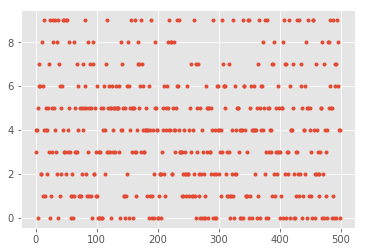

In [28]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()


F

In [29]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

## Output
* Recommendation of product based on the current product selected by user.
* To recommend related product based on, Frequently bought together. 

#### Top words in each cluster based on product description

In [30]:
# # Optimal clusters is 

true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 water
 toilet
 flush
 bowl
 spray
 tank
 wax
 easy
 ice
 azek
Cluster 1:
 light
 air
 fan
 watt
 ft
 cooling
 led
 control
 stake
 use
Cluster 2:
 door
 moulding
 wood
 ft
 proposition
 nbsp
 residents
 metal
 painted
 california
Cluster 3:
 cutting
 design
 non
 pliers
 steel
 blade
 saw
 designed
 tooth
 use
Cluster 4:
 insulation
 cover
 ladder
 attic
 water
 ft
 aluminum
 fiberglass
 box
 easy
Cluster 5:
 wall
 storage
 easy
 shelves
 use
 installation
 ft
 panels
 lbs
 piece
Cluster 6:
 cooking
 oven
 ft
 cycle
 gas
 cu
 low
 water
 wash
 capacity
Cluster 7:
 tool
 power
 volt
 battery
 speed
 lithium
 m12
 easy
 ion
 amp
Cluster 8:
 paint
 projects
 tape
 used
 outdoor
 wood
 surfaces
 finish
 plastic
 recommended
Cluster 9:
 collection
 patio
 outdoor
 bronze
 frame
 dining
 rug
 hardware
 nickel
 cushions


#### Predicting clusters based on key search words

In [31]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

* **Keyword : ** cutting tool

In [32]:
show_recommendations("cutting tool")

Cluster 3:
 cutting
 design
 non
 pliers
 steel
 blade
 saw
 designed
 tooth
 use


* **Keyword : **spray paint

In [33]:
show_recommendations("spray paint")

Cluster 8:
 paint
 projects
 tape
 used
 outdoor
 wood
 surfaces
 finish
 plastic
 recommended


* **Keyword : **steel drill

In [34]:
show_recommendations("steel drill")

Cluster 2:
 door
 moulding
 wood
 ft
 proposition
 nbsp
 residents
 metal
 painted
 california


In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word.

* **Keyword : **water

In [35]:
show_recommendations("water")

Cluster 0:
 water
 toilet
 flush
 bowl
 spray
 tank
 wax
 easy
 ice
 azek


Once a cluster is identified based on the user's search words, the recommendation system can display items from the corresponding product clusters based on the product descriptions.

#### Summary: 

This works best if a business is setting up its e-commerce website for the first time and does not have user-item purchase/rating history to start with initally. This recommendation system will help the users get a good recommendation to start with and once the buyers have a purchased history, the recommendation engine can use the model based collaborative filtering technique.